In [1]:
%matplotlib inline
from collections import Counter, OrderedDict, defaultdict
import copy
import glob
from itertools import izip
import itertools
import os
import subprocess
import tempfile

from IPython.core.display import HTML, Image
import itertools
import pandas as pd
from matplotlib import gridspec
from matplotlib_venn import venn2, venn3
from matplotlib import pyplot
import numpy as np
import scipy
import seaborn as sns

from clipper.src import CLIP_analysis
from clipper.src import get_genomic_regions
import flotilla
from gscripts import GO
from gscripts.general import dataviz
from gscripts.general import parsers
from gscripts.general import region_helpers
from gscripts.rnaseq.helpers import counts_to_rpkm

img_dir = "/home/gpratt/Dropbox/cryptic_splicing/data/human_data/figures"


:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
count_df = pd.read_table("/home/gpratt/projects/cryptic_exons/analysis/av_resequencing_v2/all_counts.txt", skiprows=1, index_col=0)
count_df.columns = [os.path.basename(item).split(".")[0] for item in count_df.columns]
rpkm_df = counts_to_rpkm(count_df).T

count_df[count_df.columns[5:]].to_csv("/home/gpratt/Dropbox/cryptic_splicing/data/human_data/important_counts.csv")

In [3]:
all_splicing_events = pd.read_csv("/home/gpratt/projects/cryptic_exons/analysis/av_resequencing_v2/combined_output/miso_summary_filtered.csv", index_col=[-2, 2, -1])

In [4]:
all_splicing_events.groupby(level=["sample_id", "splice_type"]).count().miso_posterior_mean.unstack()

/home/gpratt/anaconda/lib/python2.7/site-packages/pandas/core/index.py:4281: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return np.sum(name == np.asarray(self.names)) > 1


splice_type,A3SS,A5SS,AFE,ALE,MXE,RI,SE,TANDEMUTR
sample_id,,,,,,,,
AV_47d_1_S50_L008_R1_001,8245,5637,14993,7993,4999,4830,26741,2216
AV_47d_puro_1_S51_L008_R1_001,8173,5650,14985,8107,4881,4824,26811,2233
AV_ALS17_5_1_S45_L007_R1_001,8290,5734,14951,8015,5005,4855,26918,2245
AV_ALS17_5_puro_1_S46_L007_R1_001,8143,5565,14853,8172,4907,4829,26821,2245
AV_CVB_S56_L008_R1_001,7766,5331,14337,7736,4681,4737,25143,2174
AV_CVB_puro_S49_L007_R1_001,7512,5126,14539,7939,4584,4705,24593,2202
AV_GY6_2_1_S43_L007_R1_001,8400,5785,15162,8078,5070,4907,27346,2259
AV_GY6_2_puro_1_S44_L007_R1_001,1785,NaN,15326,8284,5208,NaN,28075,NaN
AV_Kin1ALS17_3_S47_L007_R1_001,7230,4975,13740,7573,4342,4519,23470,2145


In [5]:
all_splicing_events = pd.read_csv("/home/gpratt/projects/cryptic_exons/analysis/av_resequencing_v2/combined_output/miso_summary_filtered.csv", index_col=[-2, 2])
se_splicing_events = all_splicing_events[all_splicing_events.splice_type == "SE"]
splicing_df = se_splicing_events.groupby(level=["sample_id", "event_name"]).first().miso_posterior_mean.unstack().fillna(.5)

In [6]:
mutant_dict = {"AV_47d": ("TDP", "G298S"),
              "AV_ALS17_5": ("WT", "N352S"),
               "AV_CVB": ("WT", "WT"),
               "AV_GY6_2": ("TDP", "R521G"),
               "AV_Kin1ALS17_3": ("TDP", "WT"),
               "KK_MN": ("WT", "WT")
              }

In [7]:
metadata = pd.DataFrame(index=splicing_df.index)
metadata['cell_type'] = "MN"
metadata['exp'] = ["_".join(item.split("_")[:-4]) for item in metadata.index]
metadata['stress'] = ["puro" in item for item in metadata.index]
metadata['outlier'] = False
metadata['phenotype'] = ["_".join(item.split("_")[:-4]) for item in metadata.index]
metadata['paired_with_stress'] = ["KK" not in item for item in metadata.index] 


rbp = []
mutation = []
genotype_lst = []
for item in metadata.index:
    for genotype in mutant_dict:
        if genotype in item:
            rbp.append(mutant_dict[genotype][0])
            mutation.append(mutant_dict[genotype][1])
            genotype_lst.append(genotype)
            
metadata['rbp'] = rbp
metadata['mutation'] = mutation
metadata['genotype'] = genotype_lst

In [8]:
metadata

,cell_type,exp,stress,outlier,phenotype,paired_with_stress,rbp,mutation,genotype
sample_id,,,,,,,,,
AV_47d_1_S50_L008_R1_001,MN,AV_47d_1,False,False,AV_47d_1,True,TDP,G298S,AV_47d
AV_47d_puro_1_S51_L008_R1_001,MN,AV_47d_puro_1,True,False,AV_47d_puro_1,True,TDP,G298S,AV_47d
AV_ALS17_5_1_S45_L007_R1_001,MN,AV_ALS17_5_1,False,False,AV_ALS17_5_1,True,WT,N352S,AV_ALS17_5
AV_ALS17_5_puro_1_S46_L007_R1_001,MN,AV_ALS17_5_puro_1,True,False,AV_ALS17_5_puro_1,True,WT,N352S,AV_ALS17_5
AV_CVB_S56_L008_R1_001,MN,AV_CVB,False,False,AV_CVB,True,WT,WT,AV_CVB
AV_CVB_puro_S49_L007_R1_001,MN,AV_CVB_puro,True,False,AV_CVB_puro,True,WT,WT,AV_CVB
AV_GY6_2_1_S43_L007_R1_001,MN,AV_GY6_2_1,False,False,AV_GY6_2_1,True,TDP,R521G,AV_GY6_2
AV_GY6_2_puro_1_S44_L007_R1_001,MN,AV_GY6_2_puro_1,True,False,AV_GY6_2_puro_1,True,TDP,R521G,AV_GY6_2
AV_Kin1ALS17_3_S47_L007_R1_001,MN,AV_Kin1ALS17_3,False,False,AV_Kin1ALS17_3,True,TDP,WT,AV_Kin1ALS17_3


In [9]:
metadata.to_csv("/home/gpratt/Dropbox/cryptic_splicing/data/human_data/SampleInfo.csv")

In [10]:
mn_study = flotilla.Study(# The metadata describing phenotype and pooled samples
                       metadata,
                       # A version for this data
                       version='0.1.0',
                       expression_data = rpkm_df,
                       # Dataframe of the splicing data
                       splicing_data=splicing_df,
                       expression_thresh = 1,
                       species="hg19"
)

2016-02-22 14:58:33	Initializing Study
2016-02-22 14:58:33	Initializing Predictor configuration manager for Study
2016-02-22 14:58:33	Predictor ExtraTreesClassifier is of type <class 'sklearn.ensemble.forest.ExtraTreesClassifier'>
2016-02-22 14:58:33	Added ExtraTreesClassifier to default predictors
2016-02-22 14:58:33	Predictor ExtraTreesRegressor is of type <class 'sklearn.ensemble.forest.ExtraTreesRegressor'>
2016-02-22 14:58:33	Added ExtraTreesRegressor to default predictors
2016-02-22 14:58:33	Predictor GradientBoostingClassifier is of type <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>
2016-02-22 14:58:33	Added GradientBoostingClassifier to default predictors
2016-02-22 14:58:33	Predictor GradientBoostingRegressor is of type <class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'>
2016-02-22 14:58:33	Added GradientBoostingRegressor to default predictors
2016-02-22 14:58:33	Loading metadata
2016-02-22 14:58:33	Loading species metadata from ~/f

No phenotype to color mapping was provided, falling back on reasonable defaults.
No phenotype to marker (matplotlib plotting symbol) was provided, so each phenotype will be plotted as a circle in visualizations.
Error loading species hg19 data: HTTP Error 404: Not Found

https://s3-us-west-2.amazonaws.com/flotilla-projects/ercc/ERCC_Controls.txt has not been downloaded before.
2016-02-22 14:58:42	Loading expression data
2016-02-22 14:58:42	Initializing expression
2016-02-22 14:58:43	Done initializing expression
2016-02-22 14:58:45	Loading splicing data
2016-02-22 14:58:45	Initializing splicing
2016-02-22 14:58:45	Done initializing splicing
2016-02-22 14:58:45	Successfully initialized a Study object!


/home/gpratt/anaconda/lib/python2.7/site-packages/flotilla/data_model/metadata.py:188: UserWarning: MetaData.phenotype_series will be deprecated in 0.3.0
  warnings.warn('MetaData.phenotype_series will be deprecated in 0.3.0')
/home/gpratt/anaconda/lib/python2.7/site-packages/flotilla/visualize/decomposition.py:177: FutureWarning: sort is deprecated, use sort_values(inplace=True) for for INPLACE sorting
  self.magnitudes.sort(ascending=False)
/home/gpratt/anaconda/lib/python2.7/site-packages/flotilla/visualize/decomposition.py:184: FutureWarning: sort is deprecated, use sort_values(inplace=True) for for INPLACE sorting
  x.sort(ascending=True)


/home/gpratt/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


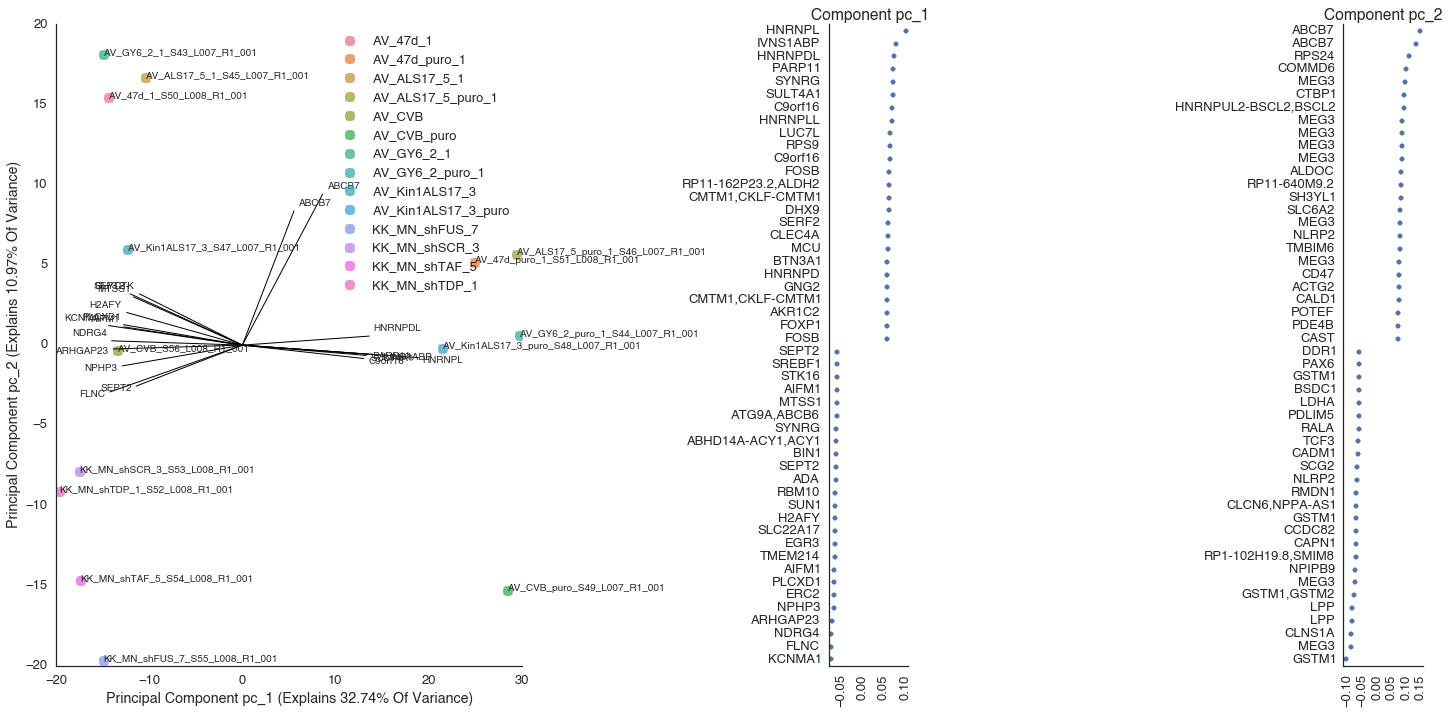

In [11]:
mn_study.plot_pca(data_type="splicing", show_point_labels=True)

In [12]:
mn_study_stress = flotilla.Study(# The metadata describing phenotype and pooled samples
                       metadata[metadata.paired_with_stress],
                       # A version for this data
                       version='0.1.0',
                       expression_data = rpkm_df[metadata.paired_with_stress],
                       # Dataframe of the splicing data
                       splicing_data=splicing_df[metadata.paired_with_stress],
                       expression_thresh = 1,
                       species="hg19"
)

2016-02-22 14:59:30	Initializing Study
2016-02-22 14:59:30	Initializing Predictor configuration manager for Study
2016-02-22 14:59:30	Predictor ExtraTreesClassifier is of type <class 'sklearn.ensemble.forest.ExtraTreesClassifier'>
2016-02-22 14:59:30	Added ExtraTreesClassifier to default predictors
2016-02-22 14:59:30	Predictor ExtraTreesRegressor is of type <class 'sklearn.ensemble.forest.ExtraTreesRegressor'>
2016-02-22 14:59:30	Added ExtraTreesRegressor to default predictors
2016-02-22 14:59:30	Predictor GradientBoostingClassifier is of type <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>
2016-02-22 14:59:30	Added GradientBoostingClassifier to default predictors
2016-02-22 14:59:30	Predictor GradientBoostingRegressor is of type <class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'>
2016-02-22 14:59:30	Added GradientBoostingRegressor to default predictors
2016-02-22 14:59:30	Loading metadata
2016-02-22 14:59:30	Loading species metadata from ~/f

/home/gpratt/anaconda/lib/python2.7/site-packages/pandas/core/frame.py:1942: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)
No phenotype to color mapping was provided, falling back on reasonable defaults.
No phenotype to marker (matplotlib plotting symbol) was provided, so each phenotype will be plotted as a circle in visualizations.
Error loading species hg19 data: HTTP Error 404: Not Found

2016-02-22 14:59:39	Loading expression data
2016-02-22 14:59:39	Initializing expression
2016-02-22 14:59:40	Done initializing expression
2016-02-22 14:59:42	Loading splicing data
2016-02-22 14:59:42	Initializing splicing
2016-02-22 14:59:42	Done initializing splicing
2016-02-22 14:59:42	Successfully initialized a Study object!


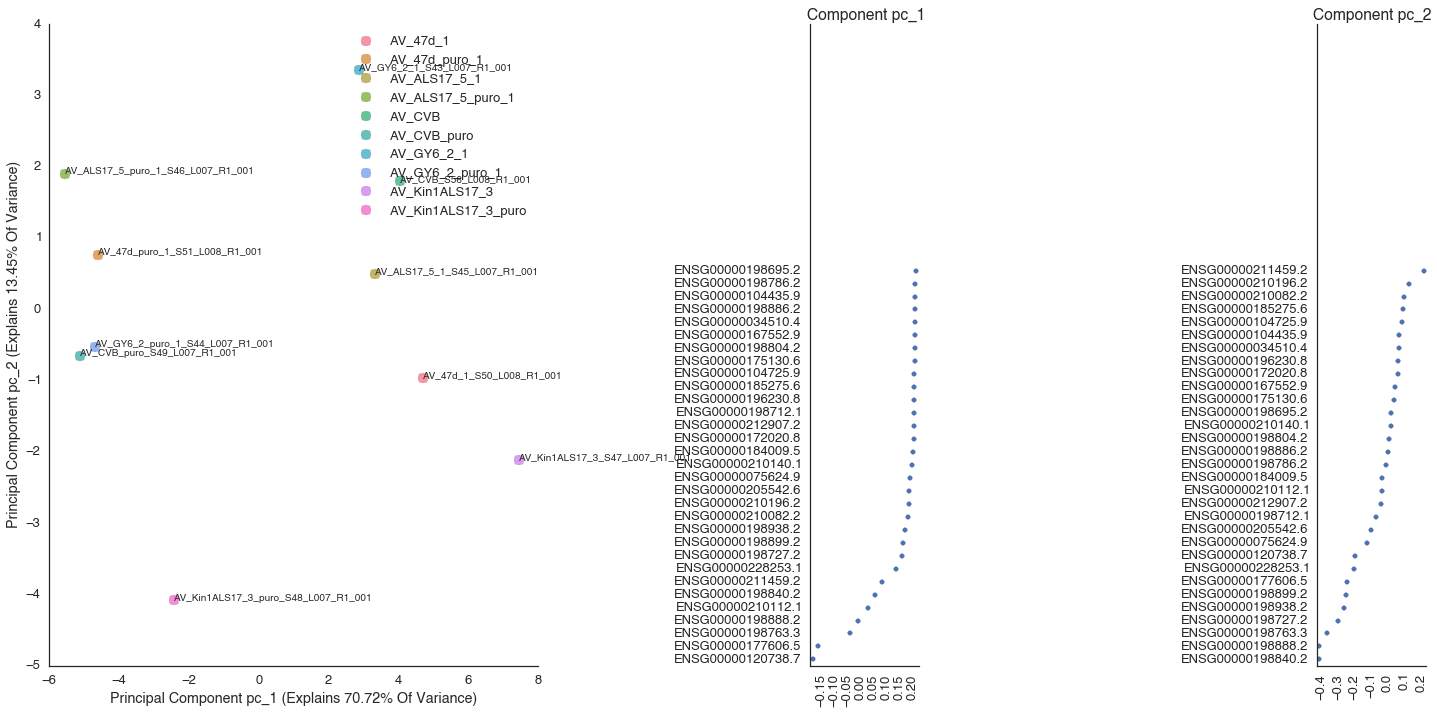

In [13]:
splicing_pca = mn_study_stress.plot_pca(data_type="expression", show_vectors=False, show_point_labels=True)
pyplot.savefig(os.path.join(img_dir, "expression_pca.svg"))
pyplot.savefig(os.path.join(img_dir, "expression_pca.pdf"))

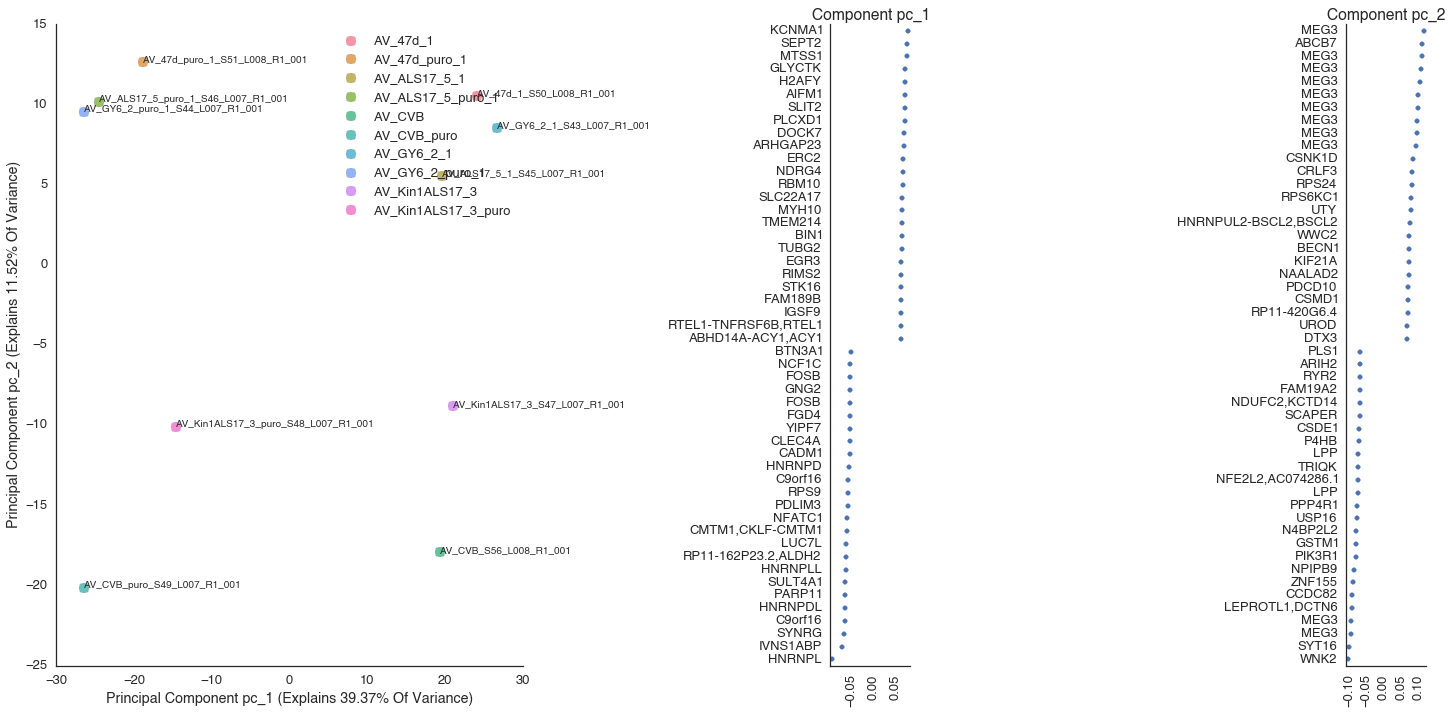

In [14]:
splicing_pca = mn_study_stress.plot_pca(data_type="splicing", show_vectors=False, show_point_labels=True)
pyplot.savefig(os.path.join(img_dir, "splicing_pca.svg"))
pyplot.savefig(os.path.join(img_dir, "splicing_pca.pdf"))

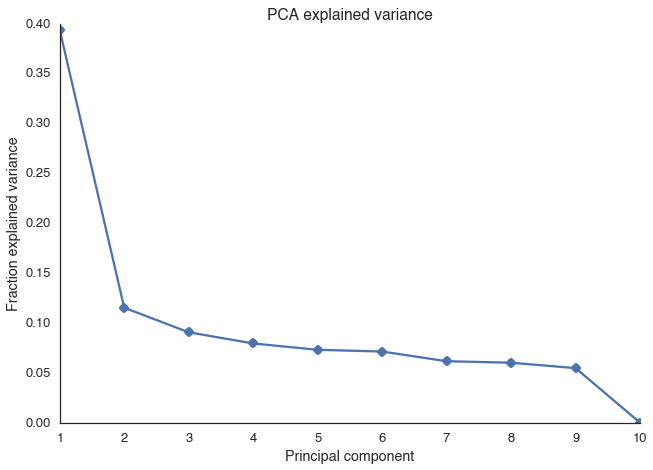

In [15]:
splicing_pca.plot_explained_variance()

#Whats the difference between stressed and unstressed samples with the same genotype

In [16]:
r2_matrix = defaultdict(dict)
for y, (name1, name2) in enumerate(itertools.permutations(rpkm_df.index, 2)):
    series1 = rpkm_df.ix[name1]
    series2 = rpkm_df.ix[name2]
    r2_matrix[name1][name2] = scipy.stats.linregress(series1, series2)[2]
r2_matrix = pd.DataFrame(r2_matrix)
r2_matrix = r2_matrix.fillna(1)

In [17]:
metadata

,cell_type,exp,stress,outlier,phenotype,paired_with_stress,rbp,mutation,genotype
sample_id,,,,,,,,,
AV_47d_1_S50_L008_R1_001,MN,AV_47d_1,False,False,AV_47d_1,True,TDP,G298S,AV_47d
AV_47d_puro_1_S51_L008_R1_001,MN,AV_47d_puro_1,True,False,AV_47d_puro_1,True,TDP,G298S,AV_47d
AV_ALS17_5_1_S45_L007_R1_001,MN,AV_ALS17_5_1,False,False,AV_ALS17_5_1,True,WT,N352S,AV_ALS17_5
AV_ALS17_5_puro_1_S46_L007_R1_001,MN,AV_ALS17_5_puro_1,True,False,AV_ALS17_5_puro_1,True,WT,N352S,AV_ALS17_5
AV_CVB_S56_L008_R1_001,MN,AV_CVB,False,False,AV_CVB,True,WT,WT,AV_CVB
AV_CVB_puro_S49_L007_R1_001,MN,AV_CVB_puro,True,False,AV_CVB_puro,True,WT,WT,AV_CVB
AV_GY6_2_1_S43_L007_R1_001,MN,AV_GY6_2_1,False,False,AV_GY6_2_1,True,TDP,R521G,AV_GY6_2
AV_GY6_2_puro_1_S44_L007_R1_001,MN,AV_GY6_2_puro_1,True,False,AV_GY6_2_puro_1,True,TDP,R521G,AV_GY6_2
AV_Kin1ALS17_3_S47_L007_R1_001,MN,AV_Kin1ALS17_3,False,False,AV_Kin1ALS17_3,True,TDP,WT,AV_Kin1ALS17_3


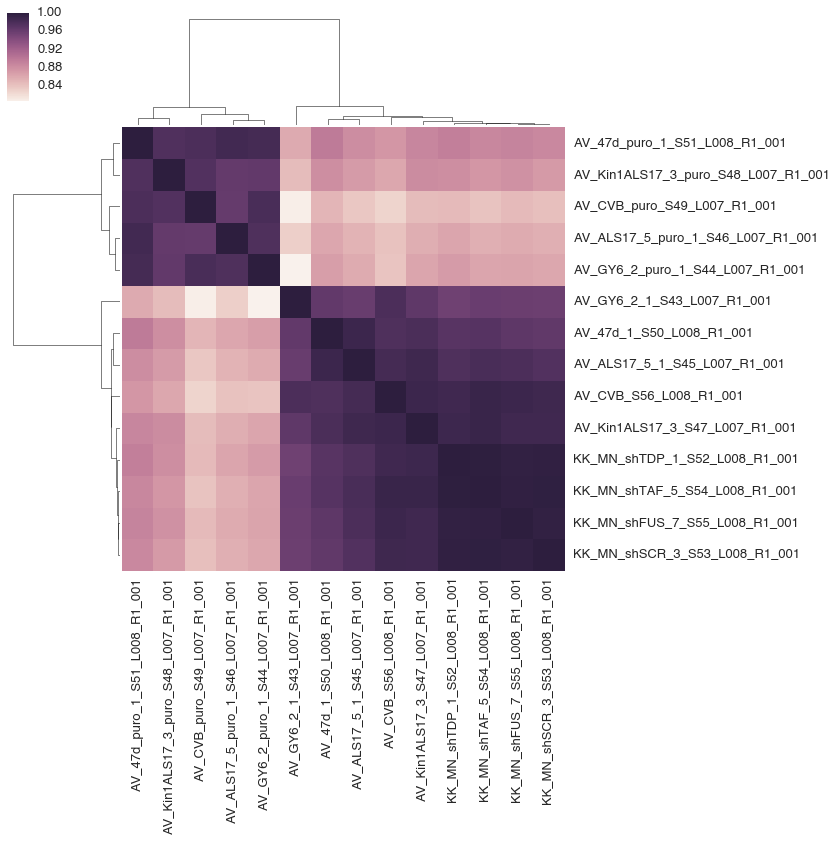

In [18]:
sns.clustermap(r2_matrix)
pyplot.savefig(os.path.join(img_dir, "correlation_clustergram.svg"))
pyplot.savefig(os.path.join(img_dir, "correlation_clustergram.pdf"))

In [19]:
stress_vs_unstress = pd.concat({os.path.basename(item).split("_")[1]: pd.read_csv(item, index_col=0) for item in glob.glob("/home/gpratt/Dropbox/cryptic_splicing/data/human_data/*stress.csv")}, names=["genotype", "gene_id"])
sig_stress_vs_unstress = stress_vs_unstress[abs(stress_vs_unstress.log2FoldChange) > 2]
sig_stress_vs_unstress_upregulated = sig_stress_vs_unstress[sig_stress_vs_unstress.log2FoldChange > 0]
sig_stress_vs_unstress_downregulated = sig_stress_vs_unstress[sig_stress_vs_unstress.log2FoldChange < 0]

We don't have technical replicates here, so estimating variance and differental gene expression is hard.  I'm just being lazy and using a lag2 fold change as calculated by DEseq2, probably should just calculate it myself though.

In [20]:
pd.concat({"upregulated": sig_stress_vs_unstress_upregulated.groupby(level="genotype").count().baseMean,
           "downregulated": sig_stress_vs_unstress_downregulated.groupby(level="genotype").count().baseMean}).unstack()

genotype,47d,ALS17,CVB,GY6,Kin1ALS17
downregulated,688,1510,1606,1580,698
upregulated,720,1558,1072,2007,647


#Look at each mutant together

/home/gpratt/anaconda/lib/python2.7/site-packages/matplotlib_venn-0.10-py2.7.egg/matplotlib_venn/_venn3.py:238: FutureWarning: using '-' to provide set differences with Indexes is deprecated, use .difference()
/home/gpratt/anaconda/lib/python2.7/site-packages/matplotlib_venn-0.10-py2.7.egg/matplotlib_venn/_venn3.py:239: FutureWarning: using '-' to provide set differences with Indexes is deprecated, use .difference()
/home/gpratt/anaconda/lib/python2.7/site-packages/matplotlib_venn-0.10-py2.7.egg/matplotlib_venn/_venn3.py:240: FutureWarning: using '-' to provide set differences with Indexes is deprecated, use .difference()
/home/gpratt/anaconda/lib/python2.7/site-packages/matplotlib_venn-0.10-py2.7.egg/matplotlib_venn/_venn3.py:241: FutureWarning: using '-' to provide set differences with Indexes is deprecated, use .difference()
/home/gpratt/anaconda/lib/python2.7/site-packages/matplotlib_venn-0.10-py2.7.egg/matplotlib_venn/_venn3.py:242: FutureWarning: using '-' to provide set differen

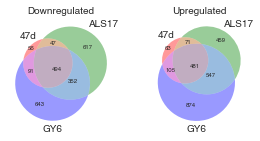

In [21]:
with dataviz.Figure(os.path.join(img_dir, "control_change.svg"), figsize=(4, 2)) as fig:
    ax = fig.add_subplot(1,2,1)
    venn = venn3([sig_stress_vs_unstress_downregulated.ix['47d'].index,
                  sig_stress_vs_unstress_downregulated.ix['ALS17'].index,
                  sig_stress_vs_unstress_downregulated.ix['GY6'].index,],
            set_labels=("47d", "ALS17", "GY6"),
            #set_colors=(rbp_colors['spinalcord'], rbp_colors['straitum'], rbp_colors['wholebrain']), 
                 ax=ax)
    ax.set_title("Downregulated", fontsize=10)
    [label.set_fontsize(6) for label in venn.subset_labels if label is not None]
    [label.set_fontsize(10) for label in venn.set_labels  if label is not None]
    
    ax = fig.add_subplot(1,2,2)
    venn = venn3([sig_stress_vs_unstress_upregulated.ix['47d'].index,
                  sig_stress_vs_unstress_upregulated.ix['ALS17'].index,
                  sig_stress_vs_unstress_upregulated.ix['GY6'].index,],
            set_labels=("47d", "ALS17", "GY6"),
            #set_colors=(rbp_colors['spinalcord'], rbp_colors['straitum'], rbp_colors['wholebrain']), 
                 ax=ax)
    ax.set_title("Upregulated", fontsize=10)
    [label.set_fontsize(6) for label in venn.subset_labels if label is not None]
    [label.set_fontsize(10) for label in venn.set_labels if label is not None]

#Compare each mutant individuall with the controls

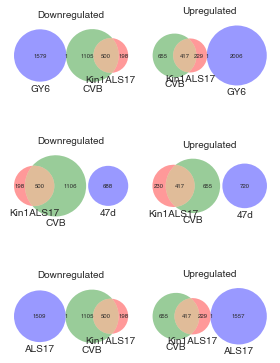

In [22]:
with dataviz.Figure(os.path.join(img_dir, "control_change.svg"), figsize=(4, 6)) as fig:
    ax = fig.add_subplot(3,2,1)
    venn = venn3([sig_stress_vs_unstress_downregulated.ix['Kin1ALS17'].index,
                  sig_stress_vs_unstress_downregulated.ix['CVB'].index,
                  sig_stress_vs_unstress_downregulated.ix['GY6'].index,],
            set_labels=("Kin1ALS17", "CVB", "GY6"),
            #set_colors=(rbp_colors['spinalcord'], rbp_colors['straitum'], rbp_colors['wholebrain']), 
                 ax=ax)
    ax.set_title("Downregulated", fontsize=10)
    [label.set_fontsize(6) for label in venn.subset_labels if label is not None]
    [label.set_fontsize(10) for label in venn.set_labels  if label is not None]
    
    ax = fig.add_subplot(3,2,2)
    venn = venn3([sig_stress_vs_unstress_upregulated.ix['Kin1ALS17'].index,
                  sig_stress_vs_unstress_upregulated.ix['CVB'].index,
                  sig_stress_vs_unstress_upregulated.ix['GY6'].index,],
            set_labels=("Kin1ALS17", "CVB", "GY6"),
            #set_colors=(rbp_colors['spinalcord'], rbp_colors['straitum'], rbp_colors['wholebrain']), 
                 ax=ax)
    ax.set_title("Upregulated", fontsize=10)
    [label.set_fontsize(6) for label in venn.subset_labels if label is not None]
    [label.set_fontsize(10) for label in venn.set_labels if label is not None]
    
    ax = fig.add_subplot(3,2,3)
    venn = venn3([sig_stress_vs_unstress_downregulated.ix['Kin1ALS17'].index,
                  sig_stress_vs_unstress_downregulated.ix['CVB'].index,
                  sig_stress_vs_unstress_downregulated.ix['47d'].index,],
            set_labels=("Kin1ALS17", "CVB", "47d"),
            #set_colors=(rbp_colors['spinalcord'], rbp_colors['straitum'], rbp_colors['wholebrain']), 
                 ax=ax)
    ax.set_title("Downregulated", fontsize=10)
    [label.set_fontsize(6) for label in venn.subset_labels if label is not None]
    [label.set_fontsize(10) for label in venn.set_labels  if label is not None]
    
    ax = fig.add_subplot(3,2,4)
    venn = venn3([sig_stress_vs_unstress_upregulated.ix['Kin1ALS17'].index,
                  sig_stress_vs_unstress_upregulated.ix['CVB'].index,
                  sig_stress_vs_unstress_upregulated.ix['47d'].index,],
            set_labels=("Kin1ALS17", "CVB", "47d"),
            #set_colors=(rbp_colors['spinalcord'], rbp_colors['straitum'], rbp_colors['wholebrain']), 
                 ax=ax)
    ax.set_title("Upregulated", fontsize=10)
    [label.set_fontsize(6) for label in venn.subset_labels if label is not None]
    [label.set_fontsize(10) for label in venn.set_labels if label is not None]
    
    ax = fig.add_subplot(3,2,5)
    venn = venn3([sig_stress_vs_unstress_downregulated.ix['Kin1ALS17'].index,
                  sig_stress_vs_unstress_downregulated.ix['CVB'].index,
                  sig_stress_vs_unstress_downregulated.ix['ALS17'].index,],
            set_labels=("Kin1ALS17", "CVB", "ALS17"),
            #set_colors=(rbp_colors['spinalcord'], rbp_colors['straitum'], rbp_colors['wholebrain']), 
                 ax=ax)
    ax.set_title("Downregulated", fontsize=10)
    [label.set_fontsize(6) for label in venn.subset_labels if label is not None]
    [label.set_fontsize(10) for label in venn.set_labels  if label is not None]
    
    ax = fig.add_subplot(3,2,6)
    venn = venn3([sig_stress_vs_unstress_upregulated.ix['Kin1ALS17'].index,
                  sig_stress_vs_unstress_upregulated.ix['CVB'].index,
                  sig_stress_vs_unstress_upregulated.ix['ALS17'].index,],
            set_labels=("Kin1ALS17", "CVB", "ALS17"),
            #set_colors=(rbp_colors['spinalcord'], rbp_colors['straitum'], rbp_colors['wholebrain']), 
                 ax=ax)
    ax.set_title("Upregulated", fontsize=10)
    [label.set_fontsize(6) for label in venn.subset_labels if label is not None]
    [label.set_fontsize(10) for label in venn.set_labels if label is not None]

#There is a clear difference between mutants and control samples, is this because there is a difference in expression originally or due to shifts due to stress?

In [23]:
stress_vs_unstress.index.levels[0]

Index([u'47d', u'ALS17', u'CVB', u'GY6', u'Kin1ALS17'], dtype='object', name=u'genotype')

In [24]:
ctrl_comparison = pd.concat({os.path.basename(item).split(".")[0]: pd.read_csv(item, index_col=0) for item in glob.glob("/home/gpratt/Dropbox/cryptic_splicing/data/human_data/*stressed.csv")}, names=["genotype", "gene_id"])
ctrl_comparison = ctrl_comparison[abs(ctrl_comparison.log2FoldChange) > 2]
ctrl_comparison_upregulated = ctrl_comparison[ctrl_comparison.log2FoldChange > 0]
ctrl_comparison_downregulated = ctrl_comparison[ctrl_comparison.log2FoldChange < 0]

In [25]:
ctrl_comparison.groupby(level="genotype").count()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
genotype,,,,,,
AV_CVB_vs_AV_47d_unstressed,3889,3889,3889,3889,3889,3889
AV_CVB_vs_AV_ALS17_5_unstressed,3709,3709,3709,3709,3709,3709
AV_CVB_vs_AV_GY6_2_unstressed,4311,4311,4311,4311,4311,4311
AV_Kin1ALS17_3_vs_AV_47d_unstressed,2227,2227,2227,2227,2227,2227
AV_Kin1ALS17_3_vs_AV_ALS17_5_unstressed,2139,2139,2139,2139,2139,2139
AV_Kin1ALS17_3_vs_AV_CVB_unstressed,2,2,2,2,2,2
AV_Kin1ALS17_3_vs_AV_GY6_2_unstressed,2499,2499,2499,2499,2499,2499


In [26]:
ctrl_comparison.index.levels[0]

Index([u'AV_CVB_vs_AV_47d_unstressed', u'AV_CVB_vs_AV_ALS17_5_unstressed',
       u'AV_CVB_vs_AV_GY6_2_unstressed',
       u'AV_Kin1ALS17_3_vs_AV_47d_unstressed',
       u'AV_Kin1ALS17_3_vs_AV_ALS17_5_unstressed',
       u'AV_Kin1ALS17_3_vs_AV_CVB_unstressed',
       u'AV_Kin1ALS17_3_vs_AV_GY6_2_unstressed'],
      dtype='object', name=u'genotype')

In [27]:
ctrl_comparison_upregulated.groupby(level="genotype").count()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
genotype,,,,,,
AV_CVB_vs_AV_47d_unstressed,2058,2058,2058,2058,2058,2058
AV_CVB_vs_AV_ALS17_5_unstressed,1855,1855,1855,1855,1855,1855
AV_CVB_vs_AV_GY6_2_unstressed,2217,2217,2217,2217,2217,2217
AV_Kin1ALS17_3_vs_AV_47d_unstressed,1369,1369,1369,1369,1369,1369
AV_Kin1ALS17_3_vs_AV_ALS17_5_unstressed,1284,1284,1284,1284,1284,1284
AV_Kin1ALS17_3_vs_AV_GY6_2_unstressed,1538,1538,1538,1538,1538,1538


In [28]:
metadata

,cell_type,exp,stress,outlier,phenotype,paired_with_stress,rbp,mutation,genotype
sample_id,,,,,,,,,
AV_47d_1_S50_L008_R1_001,MN,AV_47d_1,False,False,AV_47d_1,True,TDP,G298S,AV_47d
AV_47d_puro_1_S51_L008_R1_001,MN,AV_47d_puro_1,True,False,AV_47d_puro_1,True,TDP,G298S,AV_47d
AV_ALS17_5_1_S45_L007_R1_001,MN,AV_ALS17_5_1,False,False,AV_ALS17_5_1,True,WT,N352S,AV_ALS17_5
AV_ALS17_5_puro_1_S46_L007_R1_001,MN,AV_ALS17_5_puro_1,True,False,AV_ALS17_5_puro_1,True,WT,N352S,AV_ALS17_5
AV_CVB_S56_L008_R1_001,MN,AV_CVB,False,False,AV_CVB,True,WT,WT,AV_CVB
AV_CVB_puro_S49_L007_R1_001,MN,AV_CVB_puro,True,False,AV_CVB_puro,True,WT,WT,AV_CVB
AV_GY6_2_1_S43_L007_R1_001,MN,AV_GY6_2_1,False,False,AV_GY6_2_1,True,TDP,R521G,AV_GY6_2
AV_GY6_2_puro_1_S44_L007_R1_001,MN,AV_GY6_2_puro_1,True,False,AV_GY6_2_puro_1,True,TDP,R521G,AV_GY6_2
AV_Kin1ALS17_3_S47_L007_R1_001,MN,AV_Kin1ALS17_3,False,False,AV_Kin1ALS17_3,True,TDP,WT,AV_Kin1ALS17_3


In [29]:
with dataviz.Figure(os.path.join(img_dir, "control_change.svg"), figsize=(4, 6)) as fig:
    ax = fig.add_subplot(3,2,1)
    venn = venn3([ctrl_comparison_downregulated.ix['AV_CVB_vs_AV_47d_unstressed'].index,
                  ctrl_comparison_downregulated.ix['AV_CVB_vs_AV_ALS17_5_unstressed'].index,
                  ctr`l_comparison_downregulated.ix['AV_CVB_vs_AV_GY6_2_unstressed'].index,],
            set_labels=("AV_CVB_vs_AV_47d_unstressed", "AV_CVB_vs_AV_ALS17_5_unstressed", "AV_CVB_vs_AV_GY6_2_unstressed"),
            #set_colors=(rbp_colors['spinalcord'], rbp_colors['straitum'], rbp_colors['wholebrain']), 
                 ax=ax)
    ax.set_title("Downregulated", fontsize=10)
    [label.set_fontsize(6) for label in venn.subset_labels if label is not None]
    [label.set_fontsize(10) for label in venn.set_labels  if label is not None]
    
    ax = fig.add_subplot(3,2,2)
    venn = venn3([ctrl_comparison_upregulated.ix['AV_CVB_vs_AV_47d_unstressed'].index,
                  ctrl_comparison_upregulated.ix['AV_CVB_vs_AV_ALS17_5_unstressed'].index,
                  ctrl_comparison_upregulated.ix['AV_CVB_vs_AV_GY6_2_unstressed'].index,],
            set_labels=("AV_CVB_vs_AV_47d_unstressed", "AV_CVB_vs_AV_ALS17_5_unstressed", "AV_CVB_vs_AV_GY6_2_unstressed"),
            #set_colors=(rbp_colors['spinalcord'], rbp_colors['straitum'], rbp_colors['wholebrain']), 
                 ax=ax)
    ax.set_title("Upregulated", fontsize=10)
    [label.set_fontsize(6) for label in venn.subset_labels if label is not None]
    [label.set_fontsize(10) for label in venn.set_labels if label is not None]

SyntaxError: invalid syntax (<ipython-input-29-b56900a01c59>, line 5)

In [ ]:
with dataviz.Figure(os.path.join(img_dir, "control_change.svg"), figsize=(4, 6)) as fig:
    ax = fig.add_subplot(3,2,1)
    venn = venn3([ctrl_comparison_downregulated.ix['AV_Kin1ALS17_3_vs_AV_47d_unstressed'].index,
                  ctrl_comparison_downregulated.ix['AV_Kin1ALS17_3_vs_AV_ALS17_5_unstressed'].index,
                  ctrl_comparison_downregulated.ix['AV_Kin1ALS17_3_vs_AV_GY6_2_unstressed'].index,],
            set_labels=("AV_Kin1ALS17_3_vs_AV_47d_unstressed", "AV_Kin1ALS17_3_vs_AV_ALS17_5_unstressed", "AV_Kin1ALS17_3_vs_AV_GY6_2_unstressed"),
            #set_colors=(rbp_colors['spinalcord'], rbp_colors['straitum'], rbp_colors['wholebrain']), 
                 ax=ax)
    ax.set_title("Downregulated", fontsize=10)
    [label.set_fontsize(6) for label in venn.subset_labels if label is not None]
    [label.set_fontsize(10) for label in venn.set_labels  if label is not None]
    
    ax = fig.add_subplot(3,2,2)
    venn = venn3([ctrl_comparison_upregulated.ix['AV_Kin1ALS17_3_vs_AV_47d_unstressed'].index,
                  ctrl_comparison_upregulated.ix['AV_Kin1ALS17_3_vs_AV_ALS17_5_unstressed'].index,
                  ctrl_comparison_upregulated.ix['AV_Kin1ALS17_3_vs_AV_GY6_2_unstressed'].index,],
            set_labels=("AV_Kin1ALS17_3_vs_AV_47d_unstressed", "AV_Kin1ALS17_3_vs_AV_ALS17_5_unstressed", "AV_Kin1ALS17_3_vs_AV_GY6_2_unstressed"),
            #set_colors=(rbp_colors['spinalcord'], rbp_colors['straitum'], rbp_colors['wholebrain']), 
                 ax=ax)
    ax.set_title("Upregulated", fontsize=10)
    [label.set_fontsize(6) for label in venn.subset_labels if label is not None]
    [label.set_fontsize(10) for label in venn.set_labels if label is not None]

In [ ]:
ctrl_comparison_downregulated.index.levels[0]

In [ ]:
with dataviz.Figure(os.path.join(img_dir, "control_change.svg"), figsize=(4, 6)) as fig:
    ax = fig.add_subplot(3,2,1)
    venn = venn2([ctrl_comparison_downregulated.ix['AV_Kin1ALS17_3_vs_AV_47d_unstressed'].index,
                  ctrl_comparison_downregulated.ix['AV_CVB_vs_AV_47d_unstressed'].index,
                  ],
            set_labels=("AV_Kin1ALS17_3_vs_AV_47d_unstressed", "AV_CVB_vs_AV_47d_unstressed"),
            #set_colors=(rbp_colors['spinalcord'], rbp_colors['straitum'], rbp_colors['wholebrain']), 
                 ax=ax)
    ax.set_title("Downregulated", fontsize=10)
    [label.set_fontsize(6) for label in venn.subset_labels if label is not None]
    [label.set_fontsize(10) for label in venn.set_labels  if label is not None]
    
    ax = fig.add_subplot(3,2,2)
    venn = venn2([ctrl_comparison_upregulated.ix['AV_Kin1ALS17_3_vs_AV_47d_unstressed'].index,
                  ctrl_comparison_upregulated.ix['AV_CVB_vs_AV_47d_unstressed'].index,
                  ],
            set_labels=("AV_Kin1ALS17_3_vs_AV_47d_unstressed", "AV_CVB_vs_AV_47d_unstressed"),
            #set_colors=(rbp_colors['spinalcord'], rbp_colors['straitum'], rbp_colors['wholebrain']), 
                 ax=ax)
    ax.set_title("Upregulated", fontsize=10)
    [label.set_fontsize(6) for label in venn.subset_labels if label is not None]
    [label.set_fontsize(10) for label in venn.set_labels if label is not None]

In [ ]:
with dataviz.Figure(os.path.join(img_dir, "control_change.svg"), figsize=(4, 6)) as fig:
    ax = fig.add_subplot(3,2,1)
    venn = venn2([ctrl_comparison_downregulated.ix['AV_CVB_vs_AV_ALS17_5_unstressed'].index,
                  ctrl_comparison_downregulated.ix['AV_Kin1ALS17_3_vs_AV_ALS17_5_unstressed'].index,
                  ],
            set_labels=("AV_CVB_vs_AV_ALS17_5_unstressed", "AV_Kin1ALS17_3_vs_AV_ALS17_5_unstressed"),
            #set_colors=(rbp_colors['spinalcord'], rbp_colors['straitum'], rbp_colors['wholebrain']), 
                 ax=ax)
    ax.set_title("Downregulated", fontsize=10)
    [label.set_fontsize(6) for label in venn.subset_labels if label is not None]
    [label.set_fontsize(10) for label in venn.set_labels  if label is not None]
    
    ax = fig.add_subplot(3,2,2)
    venn = venn2([ctrl_comparison_upregulated.ix['AV_CVB_vs_AV_ALS17_5_unstressed'].index,
                  ctrl_comparison_upregulated.ix['AV_Kin1ALS17_3_vs_AV_ALS17_5_unstressed'].index,
                  ],
            set_labels=("AV_CVB_vs_AV_ALS17_5_unstressed", "AV_Kin1ALS17_3_vs_AV_ALS17_5_unstressed"),
            #set_colors=(rbp_colors['spinalcord'], rbp_colors['straitum'], rbp_colors['wholebrain']), 
                 ax=ax)
    ax.set_title("Upregulated", fontsize=10)
    [label.set_fontsize(6) for label in venn.subset_labels if label is not None]
    [label.set_fontsize(10) for label in venn.set_labels if label is not None]

In [ ]:
with dataviz.Figure(os.path.join(img_dir, "control_change.svg"), figsize=(4, 6)) as fig:
    ax = fig.add_subplot(3,2,1)
    venn = venn2([ctrl_comparison_downregulated.ix['AV_CVB_vs_AV_GY6_2_unstressed'].index,
                  ctrl_comparison_downregulated.ix['AV_Kin1ALS17_3_vs_AV_GY6_2_unstressed'].index,
                  ],
            set_labels=("AV_CVB_vs_AV_GY6_2_unstressed", "AV_Kin1ALS17_3_vs_AV_GY6_2_unstressed"),
            #set_colors=(rbp_colors['spinalcord'], rbp_colors['straitum'], rbp_colors['wholebrain']), 
                 ax=ax)
    ax.set_title("Downregulated", fontsize=10)
    [label.set_fontsize(6) for label in venn.subset_labels if label is not None]
    [label.set_fontsize(10) for label in venn.set_labels  if label is not None]
    
    ax = fig.add_subplot(3,2,2)
    venn = venn2([ctrl_comparison_upregulated.ix['AV_CVB_vs_AV_GY6_2_unstressed'].index,
                  ctrl_comparison_upregulated.ix['AV_Kin1ALS17_3_vs_AV_GY6_2_unstressed'].index,
                  ],
            set_labels=("AV_CVB_vs_AV_GY6_2_unstressed", "AV_Kin1ALS17_3_vs_AV_GY6_2_unstressed"),
            #set_colors=(rbp_colors['spinalcord'], rbp_colors['straitum'], rbp_colors['wholebrain']), 
                 ax=ax)
    ax.set_title("Upregulated", fontsize=10)
    [label.set_fontsize(6) for label in venn.subset_labels if label is not None]
    [label.set_fontsize(10) for label in venn.set_labels if label is not None]

#Go Analysis

In [ ]:
from gscripts.GO import GO

In [ ]:
hg19go = GO(GOFile="/projects/ps-yeolab/genomes/hg19/hg19.ENSG_to_GO.txt.gz")

In [ ]:
hg19go.enrichment(ctrl_comparison_downregulated.index.get_level_values(level=1))